# 1. Install libraries

In [1]:
!pip install -q mediapipe torch_geometric Pillow_heif
print("Libraries installed.")

Libraries installed.


In [2]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
import os
import cv2

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from PIL import Image, UnidentifiedImageError
from pillow_heif import register_heif_opener
register_heif_opener()

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

from torchvision import models, transforms
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch.utils.data import Dataset as TorchDataset

from torch_geometric.nn import GINConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader

import networkx as nx

# 2. Data Loading


In [4]:
# setup MediaPipe
!wget -q -O face_landmarker.task https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task
base_options = python.BaseOptions(model_asset_path='face_landmarker.task')
options = vision.FaceLandmarkerOptions(
    base_options=base_options,
    output_face_blendshapes=False,
    output_facial_transformation_matrixes=False,
    num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

In [5]:
# define edges
connections = list(vision.FaceLandmarksConnections.FACE_LANDMARKS_TESSELATION)
src = [c[0] if isinstance(c, tuple) else c.start for c in connections]
dst = [c[1] if isinstance(c, tuple) else c.end for c in connections]
edge_index = torch.tensor([src + dst, dst + src], dtype=torch.long)

In [6]:
# setup and load MobileNetV2
fe_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Feature extraction on {fe_device}")

Feature extraction on cuda


In [7]:
full_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

cnn_backbone = torch.nn.Sequential(*list(full_model.features.children())[:14])
cnn_backbone.to(fe_device)
cnn_backbone.eval()

cnn_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
def image_to_lightweight_graph(image_u8, original_index):
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_u8)
    detection_result = detector.detect(mp_image)
    if not detection_result.face_landmarks: return None
    landmarks = detection_result.face_landmarks[0]

    # geometry features
    geo_features = torch.tensor([[lm.x, lm.y, lm.z] for lm in landmarks],
                                dtype=torch.float32).to(fe_device)

    # CNN features
    img_tensor = cnn_transform(image_u8).unsqueeze(0).to(fe_device)
    with torch.no_grad():
        feature_map = cnn_backbone(img_tensor)

    # sampling
    landmarks_xy = np.array([[lm.x, lm.y] for lm in landmarks], dtype=np.float32)
    grid = torch.tensor(landmarks_xy * 2.0 - 1.0, device=fe_device).unsqueeze(0).unsqueeze(0)

    sampled_feats = F.grid_sample(feature_map, grid, align_corners=False)
    cnn_node_features = sampled_feats.squeeze(0).squeeze(1).permute(1, 0)

    # concatenate
    final_node_features = torch.cat([geo_features, cnn_node_features], dim=1)
    idx_tensor = torch.tensor([original_index], dtype=torch.long)

    data = Data(x=final_node_features.cpu().to(torch.float16),
                edge_index=edge_index,
                img_idx=idx_tensor)
    return data

In [9]:
# LFW
print("Downloading LFW...")
lfw_people = fetch_lfw_people(min_faces_per_person=3, resize=1.0, color=True)
images = lfw_people.images
labels = lfw_people.target

graph_dataset = []
valid_labels = []

print("Generating lightweight graphs...")
for i, (img, label) in tqdm(enumerate(zip(images, labels)), total=len(images)):
    img_u8 = (img * 255).astype(np.uint8)
    graph = image_to_lightweight_graph(img_u8, i)
    if graph is not None:
        graph.y = torch.tensor([label], dtype=torch.long)
        graph_dataset.append(graph)
        valid_labels.append(label)

INPUT_DIM = graph_dataset[0].x.shape[1]
print(f"Final Node Feature Dimension: {INPUT_DIM}")
print("RAM usage should now be significantly lower.")

Generating lightweight graphs...


  0%|          | 0/7606 [00:00<?, ?it/s]

Final Node Feature Dimension: 99
RAM usage should now be significantly lower.


# 3. Model and Evaluation Definition

In [10]:
# @title 3a. Define GAT Model
from torch_geometric.nn import GATv2Conv, global_mean_pool

class GATFaceGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels=128, out_channels=128, heads=4):
        super(GATFaceGNN, self).__init__()

        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=heads, concat=True)
        self.conv2 = GATv2Conv(hidden_channels * heads, hidden_channels, heads=heads, concat=True)
        self.conv3 = GATv2Conv(hidden_channels * heads, out_channels, heads=1, concat=False)

        # Final projection to embedding space
        self.lin = torch.nn.Linear(out_channels, out_channels)

    def forward_one(self, data):
        x, edge_index, batch = data.x.float(), data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x_in2 = x
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)
        # residual
        x = x + x_in2

        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = self.lin(x)

        # L2 normalization
        x = F.normalize(x, p=2, dim=1)
        return x

    def forward(self, data1, data2):
        return self.forward_one(data1), self.forward_one(data2)

In [11]:
# @title 3b. Train and Evaluation functions
def evaluate_accuracy(loader, model, threshold=0.5):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_g1, batch_g2, targets in loader:
            batch_g1 = batch_g1.to(device)
            batch_g2 = batch_g2.to(device)
            targets = targets.to(device)

            emb1 = model.forward_one(batch_g1)
            emb2 = model.forward_one(batch_g2)

            dists = F.pairwise_distance(emb1, emb2)

            predictions = (dists > threshold).float()

            correct += (predictions == targets).sum().item()
            total += targets.size(0)
    return correct / total

def train(model, criterion, optimizer, train_loader, val_loader, save_path, num_epochs: int = 100, restart_train: bool = False):
  print("Starting training...")

  if restart_train:
    model.load_state_dict(torch.load(save_path))
    print(f"Loaded model from {save_path} to continue training.")

  best_val_acc = 0.0
  train_losses = []

  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      for batch_a, batch_p, batch_n in train_loader:
          batch_a, batch_p, batch_n = batch_a.to(device), batch_p.to(device), batch_n.to(device)

          optimizer.zero_grad()

          emb_a = model.forward_one(batch_a)
          emb_p = model.forward_one(batch_p)
          emb_n = model.forward_one(batch_n)

          loss = criterion(emb_a, emb_p, emb_n)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      avg_train_loss = running_loss / len(train_loader)
      train_losses.append(avg_train_loss)

      # val
      val_acc = evaluate_accuracy(val_loader, model, threshold=0.5)
      print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

      if val_acc > best_val_acc:
          best_val_acc = val_acc
          torch.save(model.state_dict(), save_path)
          print(f" >>> New Best Model Saved: Acc {best_val_acc*100:.2f}%")

  print("Training Complete")
  return model, train_losses

In [12]:
# @title 3c. Evaluation on test set
def evaluate_on_test_set(model, save_path, test_loader, val_loader):
  model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))

  test_acc = evaluate_accuracy(test_loader, model, threshold=0.5)
  print(f"Final Test Accuracy: {test_acc*100:.2f}%")

  thresholds = np.arange(0.1, 1.5, 0.1)
  best_thresh_acc = 0
  best_thresh = 0

  for t in thresholds:
      acc = evaluate_accuracy(val_loader, model, threshold=t)
      if acc > best_thresh_acc:
          best_thresh_acc = acc
          best_thresh = t

  print(f"Optimized Threshold on Val: {best_thresh}")
  final_acc = evaluate_accuracy(test_loader, model, threshold=best_thresh)
  print(f"Test Accuracy with Optimized Threshold: {final_acc*100:.2f}%")

  return best_thresh

In [13]:
# @title 3d. Metrics
def metrics_and_curves(model, loader, path, thresh=0.5):
  if os.path.exists(path):
      model.load_state_dict(torch.load(path))
      print("Loaded best model checkpoint.")
  else:
      print("Warning: Checkpoint not found, using current model weights.")

  model.eval()

  all_distances = []
  all_labels = []

  print("Running inference on Test Set...")
  with torch.no_grad():
      for batch_g1, batch_g2, targets in loader:
          batch_g1 = batch_g1.to(device)
          batch_g2 = batch_g2.to(device)

          emb1 = model.forward_one(batch_g1)
          emb2 = model.forward_one(batch_g2)

          dists = F.pairwise_distance(emb1, emb2)

          all_distances.extend(dists.cpu().numpy())
          all_labels.extend(targets.cpu().numpy())

  all_distances = np.array(all_distances)
  all_labels = np.array(all_labels)

  final_threshold = thresh

  pos_indices = (all_labels == 0)
  neg_indices = (all_labels == 1)

  pos_dists = all_distances[pos_indices]
  neg_dists = all_distances[neg_indices]

  print(f"\nStats:")
  print(f"Mean Distance (Same Person): {np.mean(pos_dists):.4f} +/- {np.std(pos_dists):.4f}")
  print(f"Mean Distance (Diff Person): {np.mean(neg_dists):.4f} +/- {np.std(neg_dists):.4f}")
  print(f"Visualization Threshold: {final_threshold:.4f}")

  # plot histogram
  plt.figure(figsize=(10, 6))

  # histogram for "Same Person"
  plt.hist(pos_dists, bins=30, alpha=0.6, color='green',
          label=f'Same Person (Mean: {np.mean(pos_dists):.2f})', density=True)

  # histogram for "Different Person"
  plt.hist(neg_dists, bins=30, alpha=0.6, color='red',
          label=f'Diff Person (Mean: {np.mean(neg_dists):.2f})', density=True)

  plt.axvline(x=final_threshold, color='black', linestyle='--', linewidth=2,
              label=f'Threshold ({final_threshold:.2f})')

  plt.title("Test Set: Embedding Distance Distribution", fontsize=14)
  plt.xlabel("Euclidean Distance", fontsize=12)
  plt.ylabel("Density", fontsize=12)
  plt.legend(loc='upper right')
  plt.grid(True, alpha=0.3)
  plt.show()

  # roc curve
  y_true = (all_labels == 0).astype(int)
  y_scores = -all_distances

  fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
  roc_auc = auc(fpr, tpr)

  thresholds = np.linspace(0, 4.0, 200)
  far_list = []
  frr_list = []

  for t in thresholds:
      preds_same = (all_distances < t)

      fa = np.sum(preds_same & (all_labels == 1))
      num_diff = np.sum(all_labels == 1)
      far = fa / num_diff if num_diff > 0 else 0

      fr = np.sum((~preds_same) & (all_labels == 0))
      num_same = np.sum(all_labels == 0)
      frr = fr / num_same if num_same > 0 else 0

      far_list.append(far)
      frr_list.append(frr)

  far_list = np.array(far_list)
  frr_list = np.array(frr_list)

  # EER
  idx_eer = np.nanargmin(np.abs(far_list - frr_list))
  eer_val = (far_list[idx_eer] + frr_list[idx_eer]) / 2
  eer_thresh = thresholds[idx_eer]

  print(f"--- Verification Results ---")
  print(f"AUC: {roc_auc:.4f}")
  print(f"EER: {eer_val*100:.2f}% at Threshold {eer_thresh:.4f}")

  fig, axes = plt.subplots(1, 3, figsize=(18, 5))

  # ROC curve
  axes[0].plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
  axes[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
  axes[0].set_xlabel('False Positive Rate (FAR)')
  axes[0].set_ylabel('True Positive Rate (TAR)')
  axes[0].set_title('ROC Curve')
  axes[0].legend(loc="lower right")
  axes[0].grid(alpha=0.3)

  # FAR vs FRR Curve
  axes[1].plot(thresholds, far_list, label='FAR (False Accept)', color='red')
  axes[1].plot(thresholds, frr_list, label='FRR (False Reject)', color='blue')
  axes[1].axvline(eer_thresh, color='black', linestyle='--', label=f'EER Thresh ({eer_thresh:.2f})')
  axes[1].scatter(eer_thresh, eer_val, color='black', zorder=5)
  axes[1].set_xlabel('Distance Threshold')
  axes[1].set_ylabel('Error Rate')
  axes[1].set_title(f'FAR vs FRR (EER = {eer_val*100:.1f}%)')
  axes[1].legend()
  axes[1].grid(alpha=0.3)

  # DET curve
  axes[2].plot(far_list, frr_list, color='purple', lw=2)
  axes[2].plot([0, 1], [0, 1], color='gray', linestyle='--')
  axes[2].scatter(eer_val, eer_val, color='black', label='EER')
  axes[2].set_xlabel('False Accept Rate (FAR)')
  axes[2].set_ylabel('False Reject Rate (FRR)')
  axes[2].set_title('DET Curve')
  axes[2].legend()
  axes[2].grid(alpha=0.3)

  plt.tight_layout()
  plt.show()


In [39]:
# @title 3e. CMC
def evaluate_cmc(model, graphs, labels_list):
    model.eval()

    embeddings = []
    labels = []

    from torch_geometric.data import Batch
    print("Extracting embeddings for CMC...")
    with torch.no_grad():
        for i, graph in enumerate(graphs):
            graph = graph.to(device)
            batch = Batch.from_data_list([graph])
            emb = model.forward_one(batch)
            embeddings.append(emb.cpu())
            labels.append(labels_list[i])

    embeddings = torch.cat(embeddings)
    labels = np.array(labels)

    unique_ids = np.unique(labels)
    gallery_indices = []
    probe_indices = []

    for uid in unique_ids:
        idxs = np.where(labels == uid)[0]
        gallery_indices.append(idxs[0])
        probe_indices.extend(idxs[1:])

    if len(probe_indices) == 0:
        print("Error: Not enough images per person to create Probes.")
        return

    gallery_embs = embeddings[gallery_indices]
    gallery_lbls = labels[gallery_indices]

    probe_embs = embeddings[probe_indices]
    probe_lbls = labels[probe_indices]

    print(f"Gallery Size: {len(gallery_embs)} | Probe Size: {len(probe_embs)}")

    # calculate CMC
    dists = torch.cdist(probe_embs, gallery_embs, p=2)

    ranks = np.zeros(len(gallery_lbls))

    for i in range(len(probe_embs)):
        true_label = probe_lbls[i]
        p_dists = dists[i]
        sorted_indices = torch.argsort(p_dists).numpy()
        sorted_labels = gallery_lbls[sorted_indices]
        match_positions = np.where(sorted_labels == true_label)[0]

        if len(match_positions) > 0:
            rank = match_positions[0]
            ranks[rank:] += 1

    cmc_curve = ranks / len(probe_embs)

    print(f"Rank-1 Accuracy: {cmc_curve[0]*100:.2f}%")
    print(f"Rank-5 Accuracy: {cmc_curve[min(4, len(cmc_curve)-1)]*100:.2f}%")

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cmc_curve)+1), cmc_curve, marker='o', linestyle='-', color='green')
    plt.xlabel('Rank')
    plt.ylabel('Identification Rate (Accuracy)')
    plt.title('CMC Curve (Cumulative Match Characteristic)')
    plt.grid(True, alpha=0.3)
    plt.ylim([0, 1.05])
    max_rank_plot = min(100, len(gallery_embs))
    plt.xlim([1, max_rank_plot])
    # plt.xticks(range(1, max_rank_plot+20))
    plt.show()

# 4. Dataloaders definition

In [15]:
# @title 4a. Training Triplet Dataset
class TripletGraphDataset(TorchDataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels

        self.label_to_indices = {}
        for idx, label in enumerate(labels):
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(idx)

        self.valid_labels = [lbl for lbl, idxs in self.label_to_indices.items() if len(idxs) > 1]

    def __getitem__(self, index):
        # select anchor
        anchor_label = random.choice(self.valid_labels)
        positive_indices = self.label_to_indices[anchor_label]
        idx_a, idx_p = random.sample(positive_indices, 2)
        anchor_graph = self.graphs[idx_a]

        # select positive
        positive_graph = self.graphs[idx_p]

        # select negative
        negative_label = random.choice(self.valid_labels)
        while negative_label == anchor_label:
            negative_label = random.choice(self.valid_labels)
        idx_n = random.choice(self.label_to_indices[negative_label])
        negative_graph = self.graphs[idx_n]

        return anchor_graph, positive_graph, negative_graph

    def __len__(self):
        return len(self.graphs)

class TripletCollater:
    def __call__(self, batch):
        anchors = [b[0] for b in batch]
        positives = [b[1] for b in batch]
        negatives = [b[2] for b in batch]

        return Batch.from_data_list(anchors), Batch.from_data_list(positives), Batch.from_data_list(negatives)

In [16]:
# @title 4. Testing Pair Dataset
class GraphPairDataset(TorchDataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels
        self.label_to_indices = {label: np.where(np.array(labels) == label)[0]
                                 for label in set(labels)}
        self.unique_labels = list(self.label_to_indices.keys())
        self.valid_indices = [i for i,label in enumerate(labels)
                              if len(self.label_to_indices[label]) > 1]

    def __getitem__(self, index):
        idx1 = self.valid_indices[index]
        graph1 = self.graphs[idx1]
        label1 = self.labels[idx1]

        should_match = random.random() > 0.5

        if should_match:
            possible_indices = self.label_to_indices[label1]
            idx2 = random.choice([i for i in possible_indices if i != idx1])
            target = 0.0
        else:
            label2 = random.choice([l for l in self.unique_labels if l != label1])
            idx2 = random.choice(self.label_to_indices[label2])
            target = 1.0

        graph2 = self.graphs[idx2]
        return graph1, graph2, torch.tensor(target, dtype=torch.float32)

    def __len__(self):
        return len(self.valid_indices)

class PairCollater:
    def __call__(self, batch):
        g1 = Batch.from_data_list([b[0] for b in batch])
        g2 = Batch.from_data_list([b[1] for b in batch])
        t = torch.stack([b[2] for b in batch])
        return g1, g2, t

# 5. Closed-Set Scenario

In [32]:
# @title 5a. Image-based Split & Dataloaders (Closed-set)
for graph in graph_dataset:
  graph.to('cpu')

indices = np.arange(len(graph_dataset))

# split indices randomly
close_train_idx, close_temp_idx = train_test_split(indices, test_size=0.2, random_state=42)
close_val_idx, close_test_idx = train_test_split(close_temp_idx, test_size=0.5, random_state=42)

def get_subset(idx_list):
    graphs = [graph_dataset[i] for i in idx_list]
    labels = [valid_labels[i] for i in idx_list]
    return graphs, labels

close_train_graphs, close_train_labels = get_subset(close_train_idx)
close_val_graphs, close_val_labels = get_subset(close_val_idx)
close_test_graphs, close_test_labels = get_subset(close_test_idx)

print(f"Closed Set Split Complete:")
print(f"Total Unique IDs in Full Set: {len(set(valid_labels))}")
print(f"Training samples: {len(close_train_graphs)} (Unique IDs: {len(set(close_train_labels))})")
print(f"Validation samples: {len(close_val_graphs)} (Unique IDs: {len(set(close_val_labels))})")
print(f"Testing samples: {len(close_test_graphs)} (Unique IDs: {len(set(close_test_labels))})")

# initialize dataloaders
close_train_ds = TripletGraphDataset(close_train_graphs, close_train_labels)
close_train_loader = torch.utils.data.DataLoader(
    close_train_ds, batch_size=32, shuffle=True, collate_fn=TripletCollater()
)

close_val_ds = GraphPairDataset(close_val_graphs, close_val_labels)
close_val_loader = torch.utils.data.DataLoader(
    close_val_ds, batch_size=32, shuffle=False, collate_fn=PairCollater()
)

close_test_ds = GraphPairDataset(close_test_graphs, close_test_labels)
close_test_loader = torch.utils.data.DataLoader(
    close_test_ds, batch_size=32, shuffle=False, collate_fn=PairCollater()
)

print("Closed-set Dataloaders ready.")

Closed Set Split Complete:
Total Unique IDs in Full Set: 901
Training samples: 6028 (Unique IDs: 897)
Validation samples: 754 (Unique IDs: 377)
Testing samples: 754 (Unique IDs: 404)
Closed-set Dataloaders ready.


In [33]:
# @title 5b. Init Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {device}")

close_model = GATFaceGNN(in_channels=INPUT_DIM).to(device)
criterion = torch.nn.TripletMarginLoss(margin=0.5, p=2)

optimizer = torch.optim.Adam(close_model.parameters(), lr=0.001, weight_decay=5e-4)

num_epochs = 100

base_save_path = "close_gnn.pth"
if os.path.exists('/content/drive/MyDrive'):
    drive_dir = '/content/drive/MyDrive/biosys'
    os.makedirs(drive_dir, exist_ok=True)
    close_save_path = os.path.join(drive_dir, base_save_path)
    print(f"Saving model to Google Drive: {close_save_path}")
else:
    close_save_path = base_save_path
    print(f"Saving model locally: {close_save_path}")

Training on cuda
Saving model to Google Drive: /content/drive/MyDrive/biosys/close_gnn.pth


Starting training...
Epoch 1/25 | Train Loss: 0.2321 | Val Acc: 66.79%
 >>> New Best Model Saved: Acc 66.79%
Epoch 2/25 | Train Loss: 0.2020 | Val Acc: 55.85%
Epoch 3/25 | Train Loss: 0.1974 | Val Acc: 62.76%
Epoch 4/25 | Train Loss: 0.1884 | Val Acc: 57.77%
Epoch 5/25 | Train Loss: 0.1914 | Val Acc: 57.01%
Epoch 6/25 | Train Loss: 0.1792 | Val Acc: 63.72%
Epoch 7/25 | Train Loss: 0.1826 | Val Acc: 63.34%
Epoch 8/25 | Train Loss: 0.1743 | Val Acc: 62.19%
Epoch 9/25 | Train Loss: 0.1649 | Val Acc: 55.85%
Epoch 10/25 | Train Loss: 0.1685 | Val Acc: 59.50%
Epoch 11/25 | Train Loss: 0.1743 | Val Acc: 59.88%
Epoch 12/25 | Train Loss: 0.1660 | Val Acc: 70.63%
 >>> New Best Model Saved: Acc 70.63%
Epoch 13/25 | Train Loss: 0.1659 | Val Acc: 59.50%
Epoch 14/25 | Train Loss: 0.1663 | Val Acc: 63.15%
Epoch 15/25 | Train Loss: 0.1593 | Val Acc: 63.53%
Epoch 16/25 | Train Loss: 0.1535 | Val Acc: 61.61%
Epoch 17/25 | Train Loss: 0.1488 | Val Acc: 62.00%
Epoch 18/25 | Train Loss: 0.1473 | Val Acc: 6

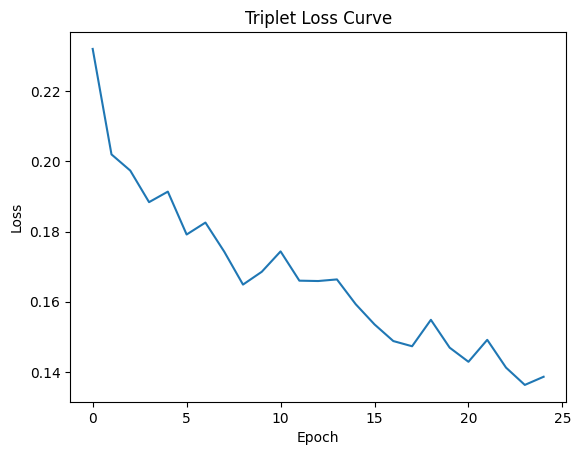

In [21]:
# @title 5c. Train and Print Losses
close_model, close_train_losses = train(close_model,
                                        criterion,
                                        optimizer,
                                        close_train_loader,
                                        close_val_loader,
                                        close_save_path,
                                        25,
                                        False)

# Loss plot
plt.plot(close_train_losses)
plt.title("Triplet Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [19]:
# @title 5d. Test Set Evaluation
best_thresh = evaluate_on_test_set(close_model,
                                   close_save_path,
                                   close_test_loader,
                                   close_val_loader)

Final Test Accuracy: 66.40%
Optimized Threshold on Val: 0.9
Test Accuracy with Optimized Threshold: 74.90%


Loaded best model checkpoint.
Running inference on Test Set...

Stats:
Mean Distance (Same Person): 0.5673 +/- 0.2430
Mean Distance (Diff Person): 1.0286 +/- 0.3965
Visualization Threshold: 0.7000


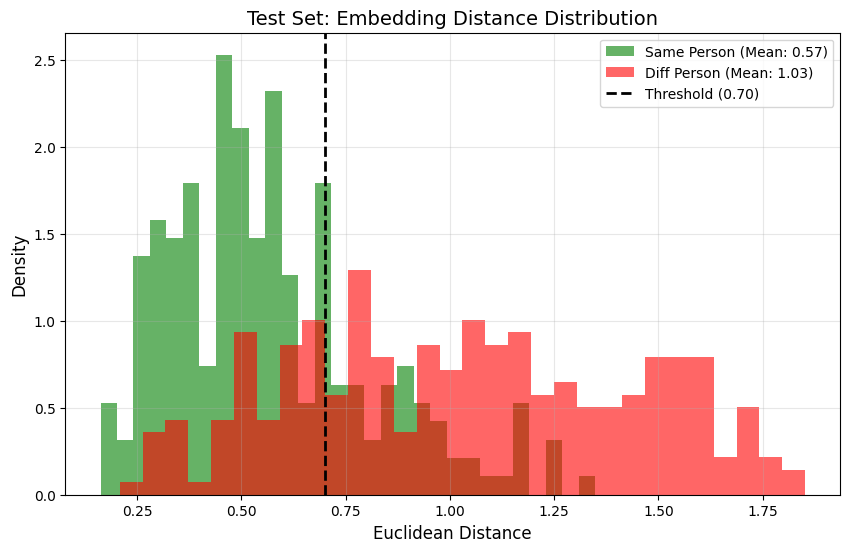

--- Verification Results ---
AUC: 0.8325
EER: 24.27% at Threshold 0.7035


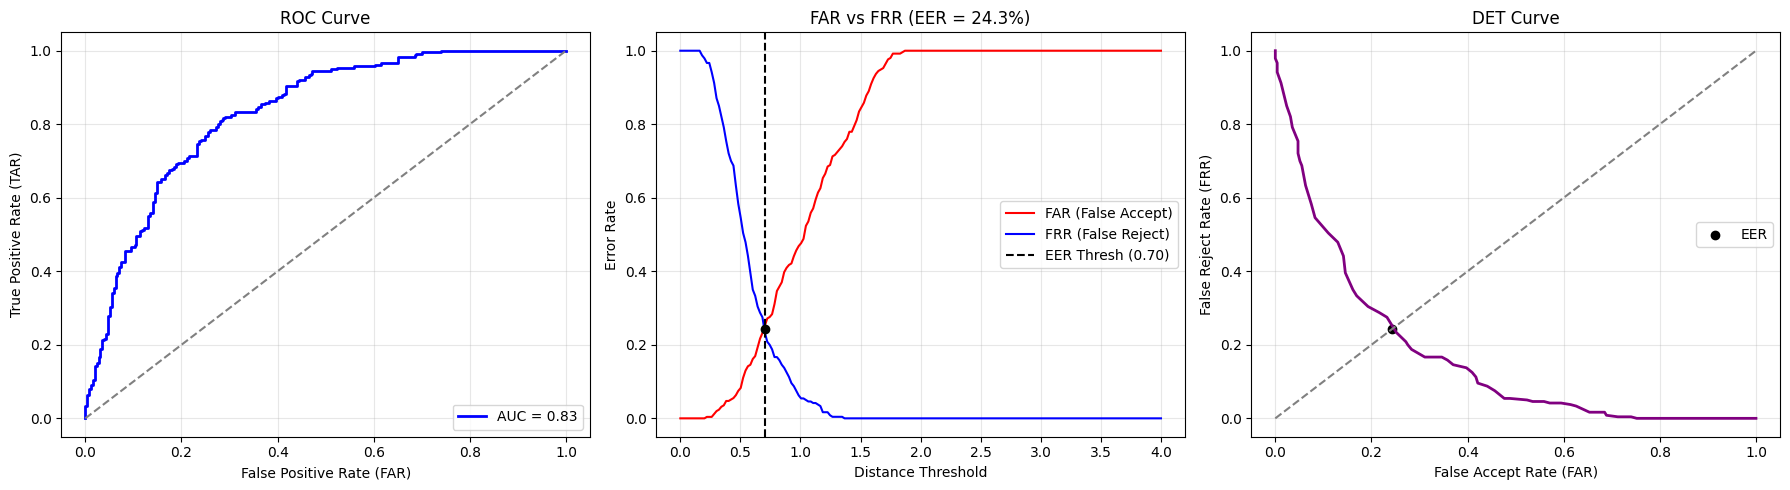

Extracting embeddings for CMC...
Gallery Size: 404 | Probe Size: 350
Rank-1 Accuracy: 4.29%
Rank-5 Accuracy: 16.86%


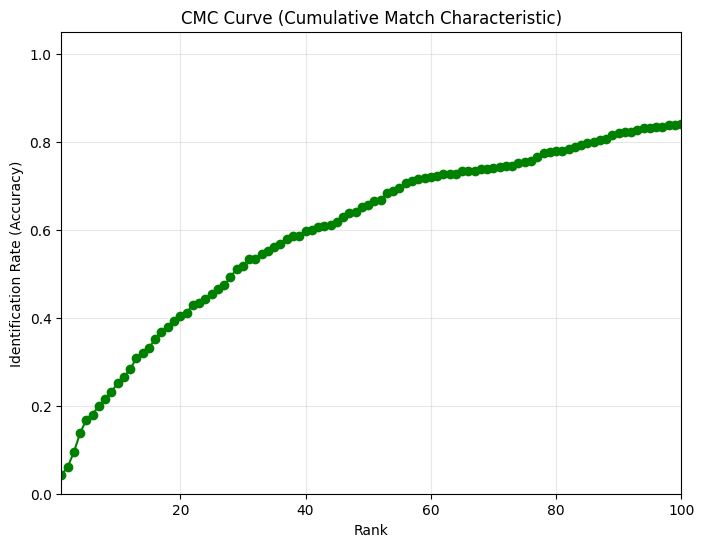

In [40]:
# @title 5e. Metrics and Curves and CMC
metrics_and_curves(close_model,
                   close_test_loader,
                   close_save_path,
                   float(best_thresh))

evaluate_cmc(close_model, close_test_graphs, close_test_labels)

# 6. Open-Set Scenario

In [41]:
# @title 6a. Identity-based Split & Dataloaders (Open-set)
for graph in graph_dataset:
  graph.to('cpu')

unique_ids = list(set(valid_labels))
print(f"Total unique identities: {len(unique_ids)}")

# split by identities
open_train_ids, open_temp_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)
open_val_ids, open_test_ids = train_test_split(open_temp_ids, test_size=0.5, random_state=42)
print(f"Train IDs: {len(open_train_ids)} | Val IDs: {len(open_val_ids)} | Test IDs: {len(open_test_ids)}")

# filter graphs based on identities
def filter_graphs(ids_list):
    id_set = set(ids_list)
    graphs = []
    labels = []
    for graph, label in zip(graph_dataset, valid_labels):
        if label in id_set:
            graphs.append(graph)
            labels.append(label)
    return graphs, labels

open_train_graphs, open_train_labels = filter_graphs(open_train_ids)
open_val_graphs, open_val_labels = filter_graphs(open_val_ids)
open_test_graphs, open_test_labels = filter_graphs(open_test_ids)

print(f"Training graphs: {len(open_train_graphs)}")
print(f"Validation graphs: {len(open_val_graphs)}")
print(f"Testing graphs: {len(open_test_graphs)}")

open_train_ds = TripletGraphDataset(open_train_graphs, open_train_labels)
open_train_loader = torch.utils.data.DataLoader(
    open_train_ds,
    batch_size=32,
    shuffle=True,
    collate_fn=TripletCollater()
    )

open_val_ds = GraphPairDataset(open_test_graphs, open_test_labels)
open_val_loader = torch.utils.data.DataLoader(
    open_val_ds,
    batch_size=32,
    shuffle=False,
    collate_fn=PairCollater()
    )

open_test_ds = GraphPairDataset(open_test_graphs, open_test_labels)
open_test_loader = torch.utils.data.DataLoader(
    open_test_ds,
    batch_size=32,
    shuffle=False,
    collate_fn=PairCollater()
    )

print("Dataloaders ready.")

Total unique identities: 901
Train IDs: 720 | Val IDs: 90 | Test IDs: 91
Training graphs: 6144
Validation graphs: 707
Testing graphs: 685
Dataloaders ready.


In [42]:
# @title 6b. Init Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {device}")

open_model = GATFaceGNN(in_channels=INPUT_DIM).to(device)
criterion = torch.nn.TripletMarginLoss(margin=0.5, p=2)

optimizer = torch.optim.Adam(open_model.parameters(), lr=0.001, weight_decay=5e-4)

num_epochs = 100

base_save_path = "open_gnn.pth"
if os.path.exists('/content/drive/MyDrive'):
    drive_dir = '/content/drive/MyDrive/biosys'
    os.makedirs(drive_dir, exist_ok=True)
    open_save_path = os.path.join(drive_dir, base_save_path)
    print(f"Saving model to Google Drive: {close_save_path}")
else:
    open_save_path = base_save_path
    print(f"Saving model locally: {close_save_path}")

Training on cuda
Saving model to Google Drive: /content/drive/MyDrive/biosys/close_gnn.pth


In [ ]:
# @title 6c. Train and Print Losses
open_model, open_train_losses = train(open_model,
                                      criterion,
                                      optimizer,
                                      open_train_loader,
                                      open_val_loader,
                                      open_save_path,
                                      50,
                                      False)

# Loss plot
plt.plot(open_train_losses)
plt.title("Triplet Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [29]:
# @title 6d. Test Set Evaluation
best_thresh = evaluate_on_test_set(open_model,
                                   open_save_path,
                                   open_test_loader,
                                   open_val_loader)

Final Test Accuracy: 72.85%
Optimized Threshold on Val: 0.7000000000000001
Test Accuracy with Optimized Threshold: 76.93%


Loaded best model checkpoint.
Running inference on Test Set...

Stats:
Mean Distance (Same Person): 0.5147 +/- 0.3094
Mean Distance (Diff Person): 1.0237 +/- 0.4138
Visualization Threshold: 0.7000


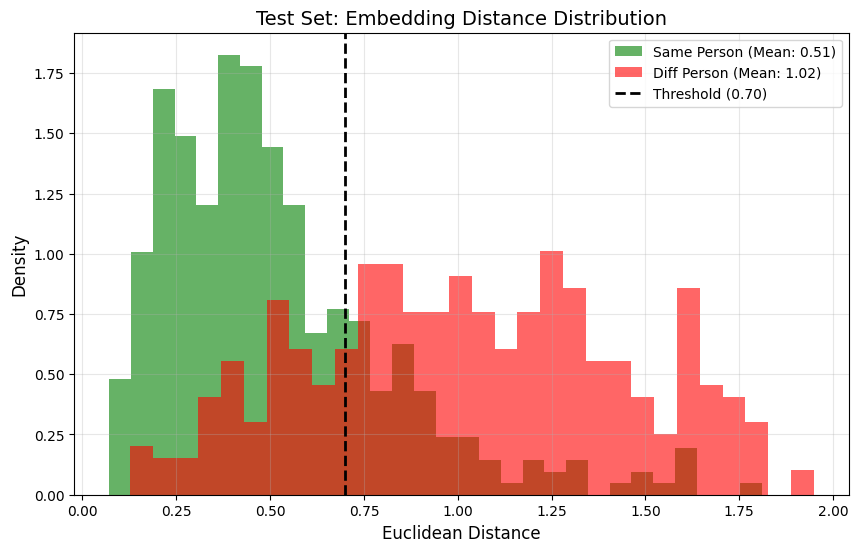

--- Verification Results ---
AUC: 0.8390
EER: 22.91% at Threshold 0.6834


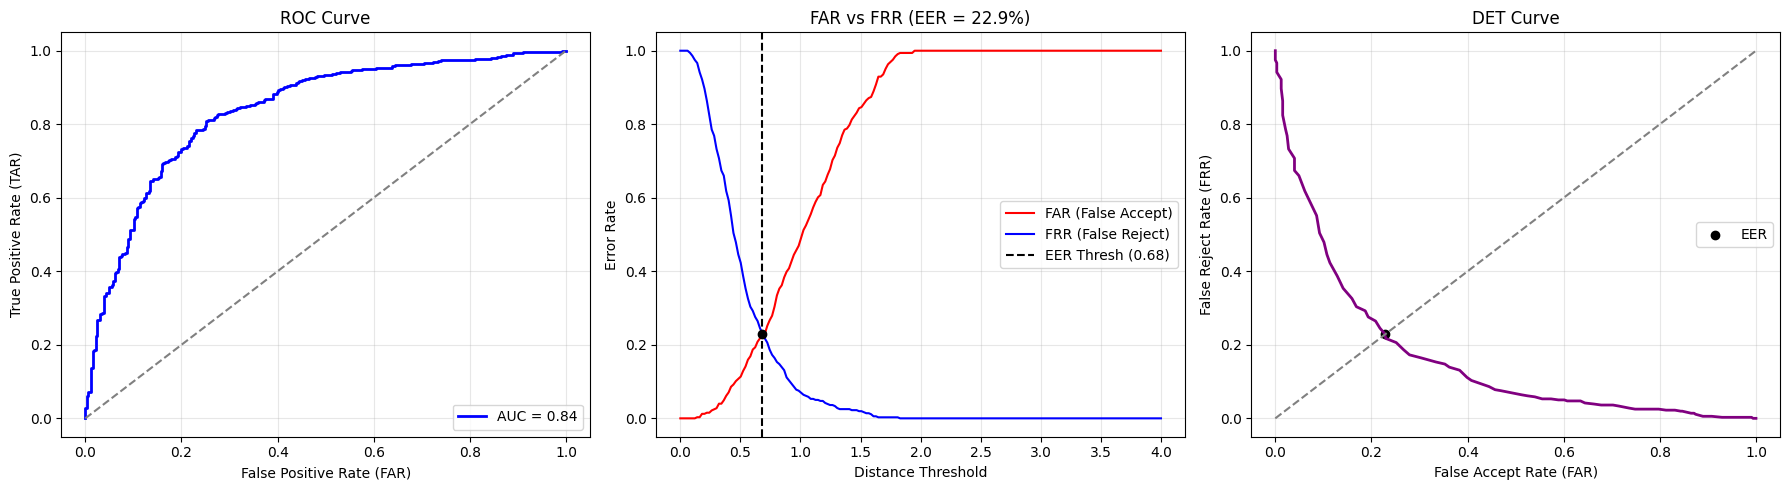

Extracting embeddings for CMC...
Gallery Size: 91 | Probe Size: 594
Rank-1 Accuracy: 15.82%
Rank-5 Accuracy: 47.47%


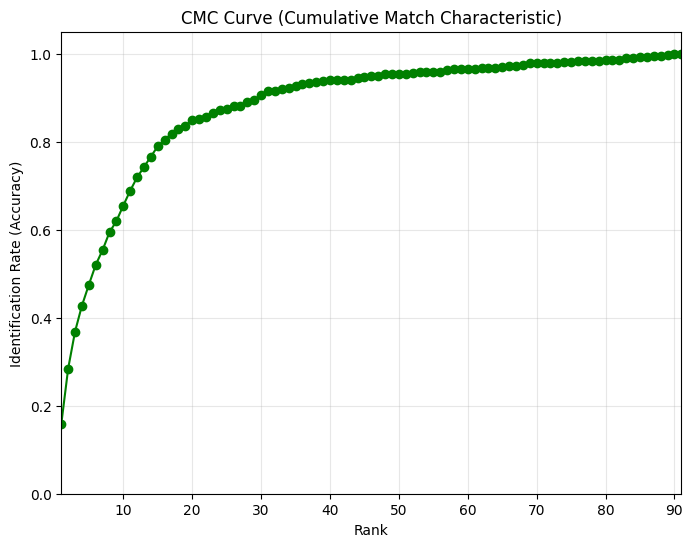

In [43]:
# @title 6e. Metrics and Curves and CMC
metrics_and_curves(open_model,
                   open_test_loader,
                   open_save_path,
                   float(best_thresh))

evaluate_cmc(open_model,
             open_test_graphs,
             open_test_labels)